# Tropical Cyclone Multi-Label Image Classification
## 3 epochs, dense layer: 1024, compare binary cross-entropy to soft F1

In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from time import time
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Read in metadata

In [81]:
grey_metadata = pd.read_csv("csv/2km_metadata.csv")
print("Number of images: {}\n".format(len(grey_metadata)))
grey_metadata.sample(6)

Number of images: 80052



,storm,vmax,scene,cat,year,id,image,exists
62047,2014al06,43.0,UNIFRM,TS,2014,2014al06_4kmsrbdc_201409132045,https://rammb-data.cira.colostate.edu/tc_realt...,True
68330,2018ep25,47.0,CRVBND,TS,2018,2018ep25_4kmsrbdc_201811031530,https://rammb-data.cira.colostate.edu/tc_realt...,True
79653,2016ep06,37.0,CRVBND,TS,2016,2016ep06_4kmsrbdc_201607201230,https://rammb-data.cira.colostate.edu/tc_realt...,True
51138,2017al17,109.8,EYE,CAT3,2017,2017al17_4kmsrbdc_201710141900,https://rammb-data.cira.colostate.edu/tc_realt...,True
46972,2017al12,43.0,UNIFRM,TS,2017,2017al12_4kmsrbdc_201709160415,https://rammb-data.cira.colostate.edu/tc_realt...,True
33999,2013ep13,37.0,CRVBND,TS,2013,2013ep13_4kmsrbdc_201309180030,https://rammb-data.cira.colostate.edu/tc_realt...,True


## Data preparation

### Analyze label frequencies

In [82]:
# add labels column
grey_metadata['labels'] = grey_metadata.cat + ',' + grey_metadata.scene
grey_metadata.head(3)

,storm,vmax,scene,cat,year,id,image,exists,labels
0,2012al09,30.0,RCDO,TD,2012,2012al09_4kmsrbdc_201208210915,https://rammb-data.cira.colostate.edu/tc_realt...,True,"TD,RCDO"
1,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208210945,https://rammb-data.cira.colostate.edu/tc_realt...,True,"TD,UNIFRM"
2,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208211015,https://rammb-data.cira.colostate.edu/tc_realt...,True,"TD,UNIFRM"


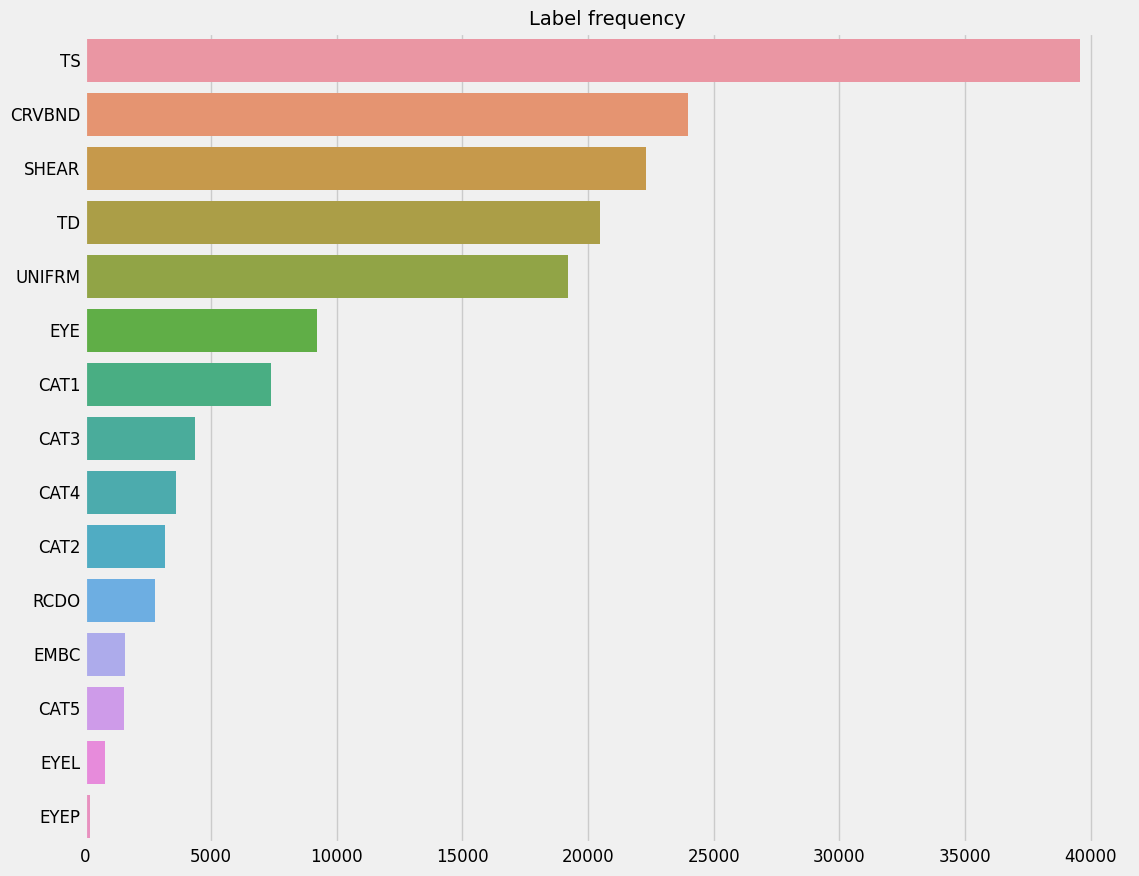

In [83]:
# Get label frequencies in descending order
label_freq = grey_metadata['labels'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Dealing with low label count
The labels `EYE`, `EYEL` and `EYEP` all refer to storms with a visible eye, so I will collapse those categories into one. 

In [84]:
grey_metadata['scene'] = grey_metadata.scene.replace('EYEL','EYE').replace('EYEP','EYE')
grey_metadata['labels'] = grey_metadata.cat + ',' + grey_metadata.scene
print(grey_metadata.scene.value_counts())
print(grey_metadata.cat.value_counts())

CRVBND    23966
SHEAR     22313
UNIFRM    19204
EYE       10208
RCDO       2771
EMBC       1590
Name: scene, dtype: int64
TS      39547
TD      20482
CAT1     7378
CAT3     4350
CAT4     3593
CAT2     3176
CAT5     1526
Name: cat, dtype: int64


In [85]:
# Transform labels column into a list of labels
grey_metadata['labels'] = grey_metadata['labels'].apply(lambda s: str(s).split(','))
grey_metadata.head(3)

,storm,vmax,scene,cat,year,id,image,exists,labels
0,2012al09,30.0,RCDO,TD,2012,2012al09_4kmsrbdc_201208210915,https://rammb-data.cira.colostate.edu/tc_realt...,True,"[TD, RCDO]"
1,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208210945,https://rammb-data.cira.colostate.edu/tc_realt...,True,"[TD, UNIFRM]"
2,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208211015,https://rammb-data.cira.colostate.edu/tc_realt...,True,"[TD, UNIFRM]"


In [87]:
# check that images exist for each observation
grey_metadata['exists'] = grey_metadata['id'].apply(lambda x: os.path.isfile('images/2km_relative_infrared/small/' + x + '.jpg'))
grey_metadata = grey_metadata[grey_metadata.exists == True].reset_index(drop=True)
grey_metadata.year.value_counts()

2018    11484
2016     9240
2020     9167
2017     8481
2015     8236
2012     7848
2014     7417
2021     7087
2019     6249
2013     4839
Name: year, dtype: int64

### Train/Test/Validation split
I'll be manually splitting out 2021 data as the test set, and reserving 20 percent of the training set for validation.

In [88]:
X_test = grey_metadata[grey_metadata.year.astype(str)=='2021']
X_test = X_test.drop(columns=['storm','vmax','scene','cat','year','image','exists']).reset_index(drop=True)
X_test

,id,labels
0,2021ep05_4kmsrbdc_202106250830,"[TS, CRVBND]"
1,2021ep05_4kmsrbdc_202106250900,"[TS, CRVBND]"
2,2021ep05_4kmsrbdc_202106250930,"[TS, CRVBND]"
3,2021ep05_4kmsrbdc_202106251000,"[TS, CRVBND]"
4,2021ep05_4kmsrbdc_202106251030,"[TS, UNIFRM]"
...,...,...
7082,2021al09_4kmsrbdc_202108271400,"[TS, UNIFRM]"
7083,2021al09_4kmsrbdc_202108271430,"[TS, UNIFRM]"
7084,2021al09_4kmsrbdc_202108271500,"[TS, UNIFRM]"
7085,2021al09_4kmsrbdc_202108271530,"[TS, UNIFRM]"


In [89]:
X_train = grey_metadata[grey_metadata.year.astype(str)!='2021']
X_train = X_train.drop(columns=['storm','vmax','scene','cat','year','image','exists']).reset_index(drop=True)
X_train

,id,labels
0,2012al09_4kmsrbdc_201208210915,"[TD, RCDO]"
1,2012al09_4kmsrbdc_201208210945,"[TD, UNIFRM]"
2,2012al09_4kmsrbdc_201208211015,"[TD, UNIFRM]"
3,2012al09_4kmsrbdc_201208211045,"[TD, UNIFRM]"
4,2012al09_4kmsrbdc_201208211115,"[TD, CRVBND]"
...,...,...
72956,2016al16_4kmsrbdc_201611250845,"[CAT1, CRVBND]"
72957,2016al16_4kmsrbdc_201611250915,"[CAT1, CRVBND]"
72958,2016al16_4kmsrbdc_201611250945,"[CAT1, CRVBND]"
72959,2016al16_4kmsrbdc_201611251015,"[CAT1, CRVBND]"


In [90]:
X_train, X_val, y_train, y_val = train_test_split(X_train['id'], X_train['labels'], test_size=0.2, random_state=42)
print("Number of images for training: ", len(X_train))
print("Number of images for validation: ", len(X_val))

Number of images for training:  58368
Number of images for validation:  14593


In [91]:
# matching entries in training metadata to actual images
X_train = [os.path.join('images/2km_relative_infrared/small/', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('images/2km_relative_infrared/small/', str(f)+'.jpg') for f in X_val]
X_train[:3]

['images/2km_relative_infrared/small/2015ep12_4kmsrbdc_201508290700.jpg',
 'images/2km_relative_infrared/small/2013ep08_4kmsrbdc_201308052200.jpg',
 'images/2km_relative_infrared/small/2020al29_4kmsrbdc_202011120700.jpg']

### Image examples
Let's display some examples of training images.

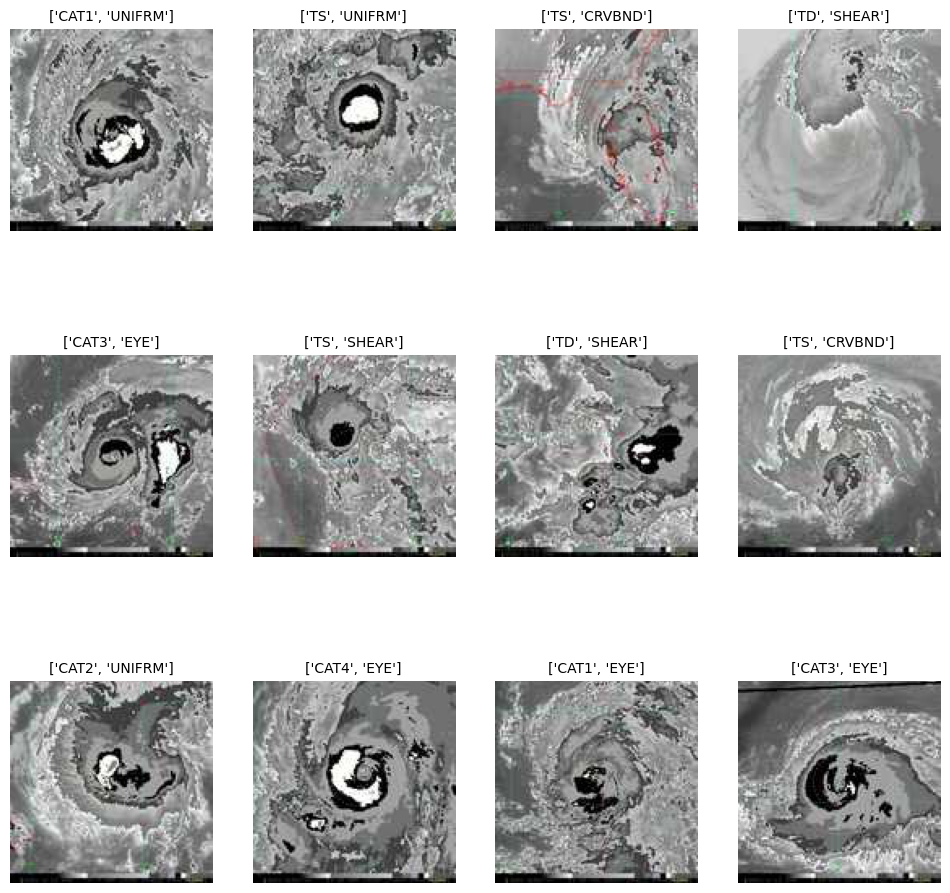

In [93]:
nobs = 12 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

### Label encoding
The original targets are lists of strings that can be easily understood by humans.  
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).  
This is critical for multi-label classification.  

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.  

In [92]:
# Prep labels for binarizer
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['CAT1', 'UNIFRM'], ['TS', 'UNIFRM'], ['TS', 'CRVBND']]

In [14]:
# Fit the multi-label binarizer on the training set and print labels for verification
print("Labels:")
binarizer = MultiLabelBinarizer()
binarizer.fit(y_train)

N_LABELS = len(binarizer.classes_)
for (i, label) in enumerate(binarizermlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. CAT1
1. CAT2
2. CAT3
3. CAT4
4. CAT5
5. CRVBND
6. EMBC
7. EYE
8. RCDO
9. SHEAR
10. TD
11. TS
12. UNIFRM


In [15]:
# transform the targets of the training and test sets
y_train_bin = binarizer.transform(y_train)
y_val_bin = binarizer.transform(y_val)

## Using tf.data to build an input pipeline

In [18]:
IMG_SIZE = 224
CHANNELS = 3

# function to parse image files into image and label arrays
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    
    # Resize and normalize
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [19]:
# I'm using AUTOTUNE to reduce idle time while training
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE 
SHUFFLE_BUFFER_SIZE = 1024 

In [20]:
# Create dataset for tensorflow
def create_dataset(filenames, labels, is_training=True):
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [21]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

Metal device set to: Apple M1


2022-03-25 06:21:11.384780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-25 06:21:11.384881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Using Transfer Learning

In [23]:
# I'm using MobileNet V2 from TensorFlow Hub
trained_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
trained_model_layer = hub.KerasLayer(trained_model,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

# freeze the pre-trained layers
trained_model_layer.trainable = False

In [24]:
# define model 
model = tf.keras.Sequential([
    trained_model_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output') # using sigmoid for multilabel classification
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 13)                13325     
                                                                 
Total params: 3,583,053
Trainable params: 1,325,069
Non-trainable params: 2,257,984
_________________________________________________________________


## Model training and evaluation

### Train the model using the binary cross-entropy loss

In [29]:
LR = 1e-5 
EPOCHS = 3

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [33]:
model_bce = tf.keras.Sequential([
    trained_model_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining time: {}'.format(print_time(time()-start)))

Epoch 1/3


2022-03-25 06:49:27.828495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - ETA: 0s - loss: 0.3075 - macro_f1: 0.2199

2022-03-25 06:53:32.493224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - 308s 1s/step - loss: 0.3075 - macro_f1: 0.2199 - val_loss: 0.2754 - val_macro_f1: 0.2752
Epoch 2/3
228/228 [==============================] - 310s 1s/step - loss: 0.2677 - macro_f1: 0.2959 - val_loss: 0.2643 - val_macro_f1: 0.2973
Epoch 3/3
228/228 [==============================] - 308s 1s/step - loss: 0.2593 - macro_f1: 0.3126 - val_loss: 0.2586 - val_macro_f1: 0.3123

Training took 0h:15m:26s


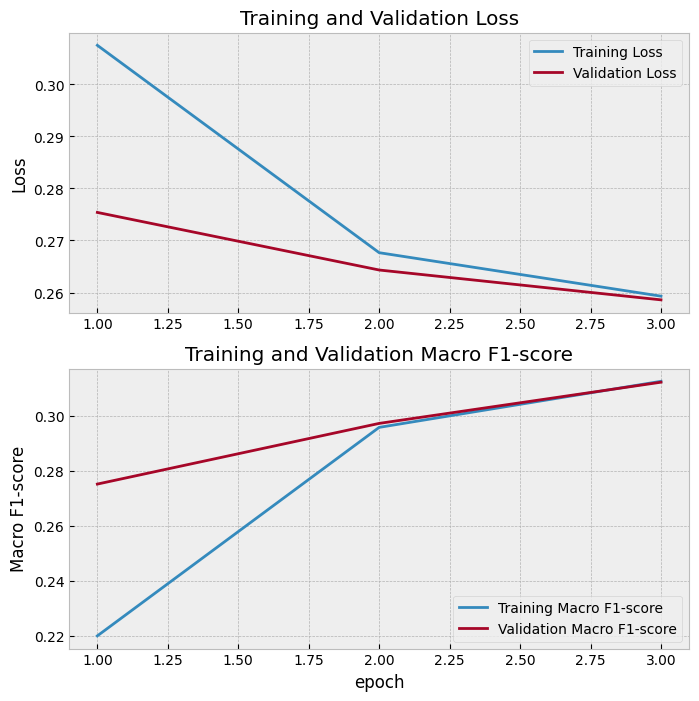

In [34]:
# plot performance
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(history_bce)

### Second Model (using macro soft-F1 loss)

I'm interested in seeing how optimizing on a probabilistic F1-score will change the model

In [26]:
@tf.function
def macro_soft_f1(y, y_hat):
 
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [27]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
  
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [30]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining time: {}'.format(print_time(time()-start)))

Epoch 1/3


2022-03-25 06:21:46.148160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - ETA: 0s - loss: 0.7373 - macro_f1: 0.2970

2022-03-25 06:25:49.765068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - 307s 1s/step - loss: 0.7373 - macro_f1: 0.2970 - val_loss: 0.6837 - val_macro_f1: 0.3698
Epoch 2/3
228/228 [==============================] - 307s 1s/step - loss: 0.6524 - macro_f1: 0.3934 - val_loss: 0.6363 - val_macro_f1: 0.3947
Epoch 3/3
228/228 [==============================] - 308s 1s/step - loss: 0.6235 - macro_f1: 0.4079 - val_loss: 0.6193 - val_macro_f1: 0.4034

Training took 0h:15m:23s


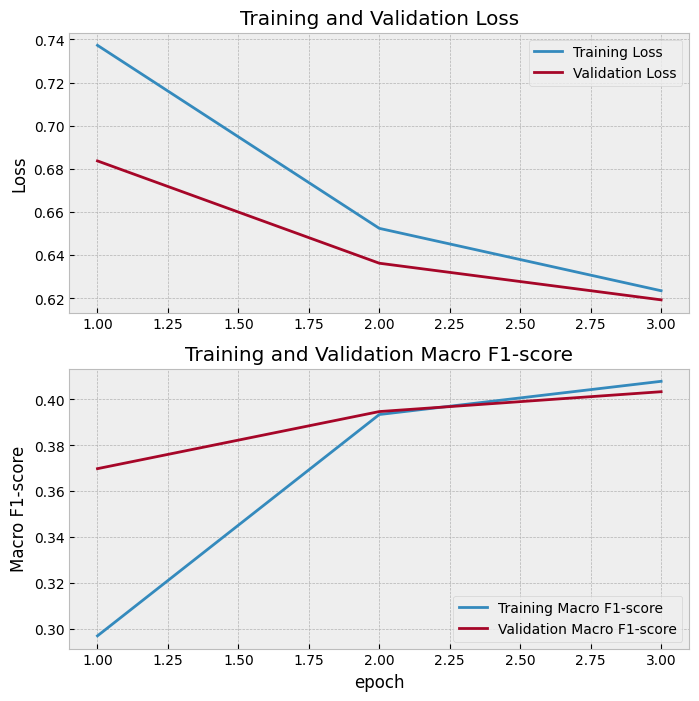

In [31]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

In [32]:
# Print performance on the validation set
print("Macro F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.62
Macro F1-score: 0.40


In [35]:
print("Macro soft-F1 loss: %.2f" %model_bce_val_losses[-1])
print("Macro F1-score: %.2f" %model_bce_val_macro_f1s[-1])

Macro soft-F1 loss: 0.26
Macro F1-score: 0.31


# Model Comparison (binary cross-entropy vs. soft F1)

In [36]:
# In the grid below, thresholds increment from 0 to 1 by a step of 0.01 for each label.  
label_names = binarizer.classes_

grid = perf_grid(val_ds, y_val_bin, label_names, model)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

2022-03-25 07:05:59.514330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-25 07:07:01.166470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [37]:
# binary cross-entropy performance grid
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,CAT1,0.09,0.00,1302,0,13291,0.089221,1.000000,0.163825
1,0,CAT1,0.09,0.01,1233,69,12446,0.090138,0.947005,0.164609
2,0,CAT1,0.09,0.02,1088,214,10853,0.091115,0.835637,0.164313
3,0,CAT1,0.09,0.03,953,349,9596,0.090340,0.731951,0.160830
4,0,CAT1,0.09,0.04,855,447,8591,0.090515,0.656682,0.159099


In [38]:
# Get the maximum F1-score for each label when using the bce model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,11,TS,0.500000,0.671008
1,5,CRVBND,0.300000,0.459842
2,9,SHEAR,0.280000,0.439585
3,10,TD,0.250000,0.400592
4,12,UNIFRM,0.240000,0.384032
5,7,EYE,0.130000,0.222966
6,0,CAT1,0.090000,0.164609
7,2,CAT3,0.050000,0.097640
8,3,CAT4,0.050000,0.089796
9,1,CAT2,0.040000,0.073786


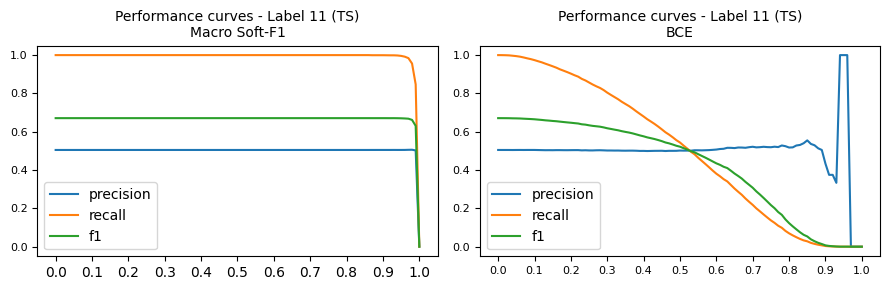

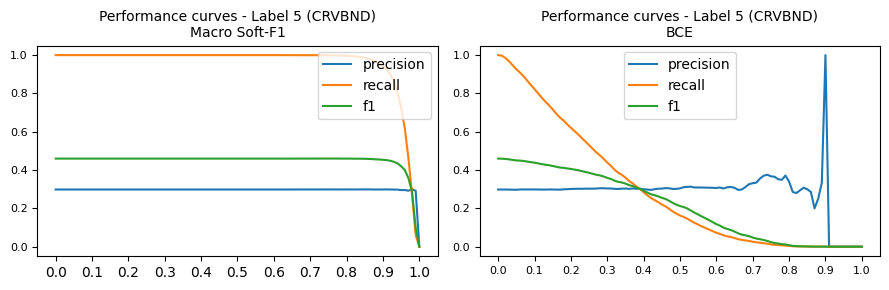

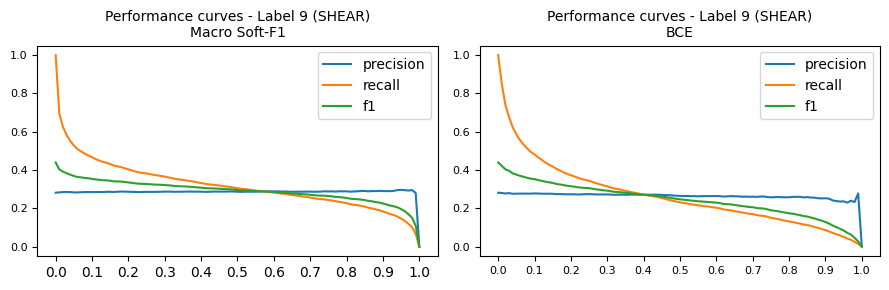

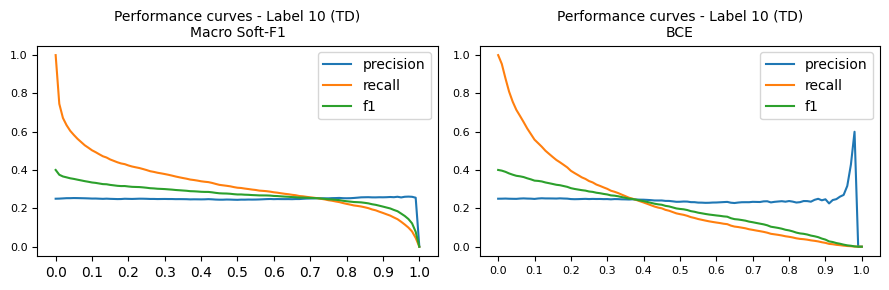

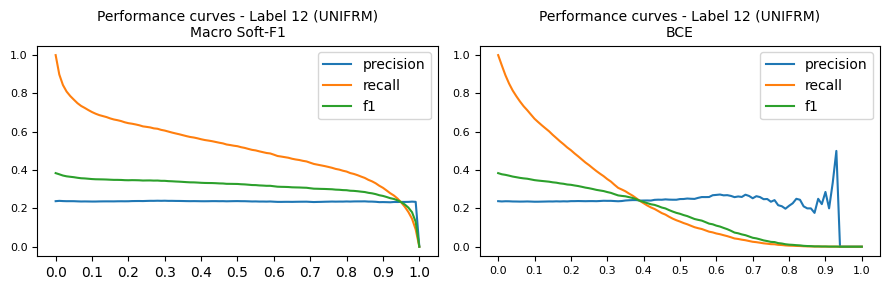

In [41]:
# Compare bce and soft F1 by plotting scores as a function of the threshold
top5 = max_perf.head(5)['id']

style.use("default")
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()
    

##  Show model predictions

In [126]:
def show_prediction(storm, df, model):
    
    # Get storm image info
    storm_id = storm
    labels = X_test.loc[X_test['id']==storm]['labels']
    img_path = os.path.join('images/2km_relative_infrared/small/', str(storm_id)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = binarizer.classes_
    prediction = prediction[prediction==1].index.values

    # Display image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nLabels\n{}\n\nPrediction\n{}\n'.format(storm, labels, list(prediction)), fontsize=9)
    plt.show()

In [127]:
X_test.sample(3)

,id,labels
2100,2021al07_4kmsrbdc_202108160530,"[TS, CRVBND]"
3280,2021ep16_4kmsrbdc_202110121800,"[CAT1, CRVBND]"
833,2021ep08_4kmsrbdc_202107310830,"[CAT1, UNIFRM]"


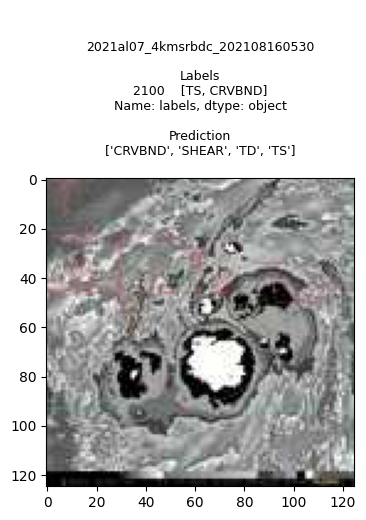

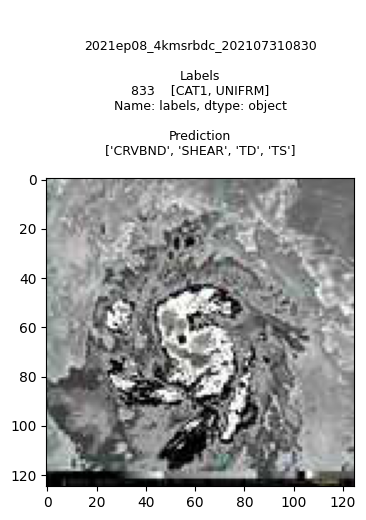

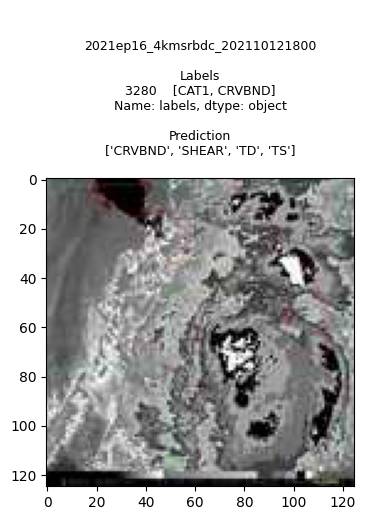

In [129]:
storms = ['2021al07_4kmsrbdc_202108160530','2021ep08_4kmsrbdc_202107310830',
          '2021ep16_4kmsrbdc_202110121800']

for s in storms:
    show_prediction(s, X_test, model)

In [122]:
storm = '2012ep15_4kmsrbdc_201210070530'
storm_id = storm
labels = grey_metadata.loc[grey_metadata['id']==storm]['labels']
labels

1897    [TS, CRVBND]
Name: labels, dtype: object

## Export models

After having trained and evaluated the two models, we can export them as a TensorFlow saved model for future use.

In [134]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/macro-f1_3_{}".format(t)
model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

export_path_bce = "./models/bce_3{}".format(t)
model_bce.save(export_path_bce)
print("Model with bce was exported in this path: '{}'".format(export_path_bce))

2022-03-25 08:08:07.630698: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model with macro soft-f1 was exported in this path: './models/macro-f1_3_20220325_080806'
Model with bce was exported in this path: './models/bce_320220325_080806'
